<a href="https://colab.research.google.com/github/ibanetz97/Matem-KPI2025/blob/main/lab3_matem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install networkx==3.1 matplotlib

# Імпорти
import itertools
import collections
import networkx as nx
import matplotlib.pyplot as plt

In [22]:
from collections import deque

# --- START of copied dependencies from preceding cells ---
# Petri net parameters from cell 7wblK3PAierU
N = 2  # кількість філософів / вилок (ЗМІНЕНО НА 2 для візуалізації)

# Опис мережі: місця (places) і переходи (transitions) з їх входами/виходами (арки з вагою=1)
# Представимо мережу як словники: inputs[tr] = {place: weight}, outputs[tr] = {place: weight}

places = []
for i in range(N):
    places += [f"Thinking_{i}", f"Hungry_{i}", f"Eating_{i}"]
for i in range(N):
    places.append(f"Fork_{i}")
places.append("Invite")  # місце для запрошення (1 токен)

# Початкове маркування: всі філософи думають, всі вилки вільні, invite = 1, інші 0
initial_marking = {p: 0 for p in places}
for i in range(N):
    initial_marking[f"Thinking_{i}"] = 1
    initial_marking[f"Fork_{i}"] = 1
initial_marking["Invite"] = 1

# Transition rules and helper functions from cell vLRl0hMjinD_
inputs = dict()
outputs = dict()

for i in range(N):
    # invite transition (за наявності Invite) - optional (але наявний)
    t_inv = f"invite_{i}"
    inputs[t_inv] = {f"Thinking_{i}": 1, "Invite": 1}
    outputs[t_inv] = {f"Hungry_{i}": 1}  # запрошення переводить в Hungry (Invite витрачається)

    # direct become hungry (без запрошення) — необов'язковий шлях
    t_direct = f"become_hungry_{i}"
    inputs[t_direct] = {f"Thinking_{i}": 1}
    outputs[t_direct] = {f"Hungry_{i}": 1}

    # start eating: вхід Hungry_i, Fork_i (ліва), Fork_{i+1} (права)
    left = f"Fork_{i}"
    right = f"Fork_{(i+1)%N}"
    t_start = f"start_eating_{i}"
    inputs[t_start] = {f"Hungry_{i}": 1, left: 1, right: 1}
    outputs[t_start] = {f"Eating_{i}": 1}

    # finish eating: повертає вилки і переходить у Thinking, а також повертає Invite (модель спрощена)
    t_finish = f"finish_eating_{i}"
    inputs[t_finish] = {f"Eating_{i}": 1}
    outputs[t_finish] = {f"Thinking_{i}": 1, left: 1, right: 1, "Invite": 1}

# Список всіх переходів
transitions = list(inputs.keys())

# Функції для роботи з маркуваннями
def marking_to_tuple(m):
    # порядок місць визначений списком places
    return tuple(m[p] for p in places)

def tuple_to_marking(tup):
    return {p: tup[i] for i, p in enumerate(places)}

def enabled_transitions(marking):
    enabled = []
    for tr in transitions:
        req = inputs[tr]
        ok = True
        for p, w in req.items():
            if marking.get(p,0) < w:
                ok = False
                break
        if ok:
            enabled.append(tr)
    return enabled

def fire_transition(marking, tr):
    m = marking.copy()
    for p, w in inputs[tr].items():
        m[p] -= w
    for p, w in outputs[tr].items():
        m[p] = m.get(p,0) + w
    return m
# --- END of copied dependencies ---

# Максимальна кількість станів, які потрібно дослідити, щоб уникнути зависання
MAX_STATES = 1000  # Можна налаштувати (ЗМЕНШЕНО)
PROGRESS_REPORT_INTERVAL = 10000 # Звіт про прогрес кожні N станів

start = initial_marking
start_t = marking_to_tuple(start)

seen = {start_t: 0}  # відмітка -> id
markings = [start_t]
edges = []  # (from_id, to_id, transition)

q = deque([start_t])
state_count = 0

print("Починаємо побудову графа досяжних розміток (BFS)...")
while q:
    cur_t = q.popleft()
    cur_id = seen[cur_t]
    cur_m = tuple_to_marking(cur_t)
    enabled = enabled_transitions(cur_m)

    state_count += 1
    if state_count % PROGRESS_REPORT_INTERVAL == 0:
        print(f"Прогрес: Досліджено {state_count} станів, {len(markings)} унікальних маркувань знайдено.")

    if len(markings) >= MAX_STATES:
        print(f"Досягнуто максимальної кількості станів ({MAX_STATES}). Зупиняємо BFS.")
        break

    for tr in enabled:
        new_m = fire_transition(cur_m, tr)
        new_t = marking_to_tuple(new_m)
        if new_t not in seen:
            seen[new_t] = len(markings)
            markings.append(new_t)
            q.append(new_t)
        edges.append((cur_id, seen[new_t], tr))

# Результати
print(f"Кількість досяжних маркувань: {len(markings)}")
print("Пара прикладів маркувань (перші 5):")
for i, mt in enumerate(markings[:5]):
    print(i, tuple_to_marking(mt))

Починаємо побудову графа досяжних розміток (BFS)...
Досягнуто максимальної кількості станів (1000). Зупиняємо BFS.
Кількість досяжних маркувань: 1000
Пара прикладів маркувань (перші 5):
0 {'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 1}
1 {'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 0}
2 {'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 1}
3 {'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'Thinking_1': 0, 'Hungry_1': 1, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 0}
4 {'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'Thinking_1': 0, 'Hungry_1': 1, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 1}


Кількість тупикових станів: 0
Візуалізація графа...


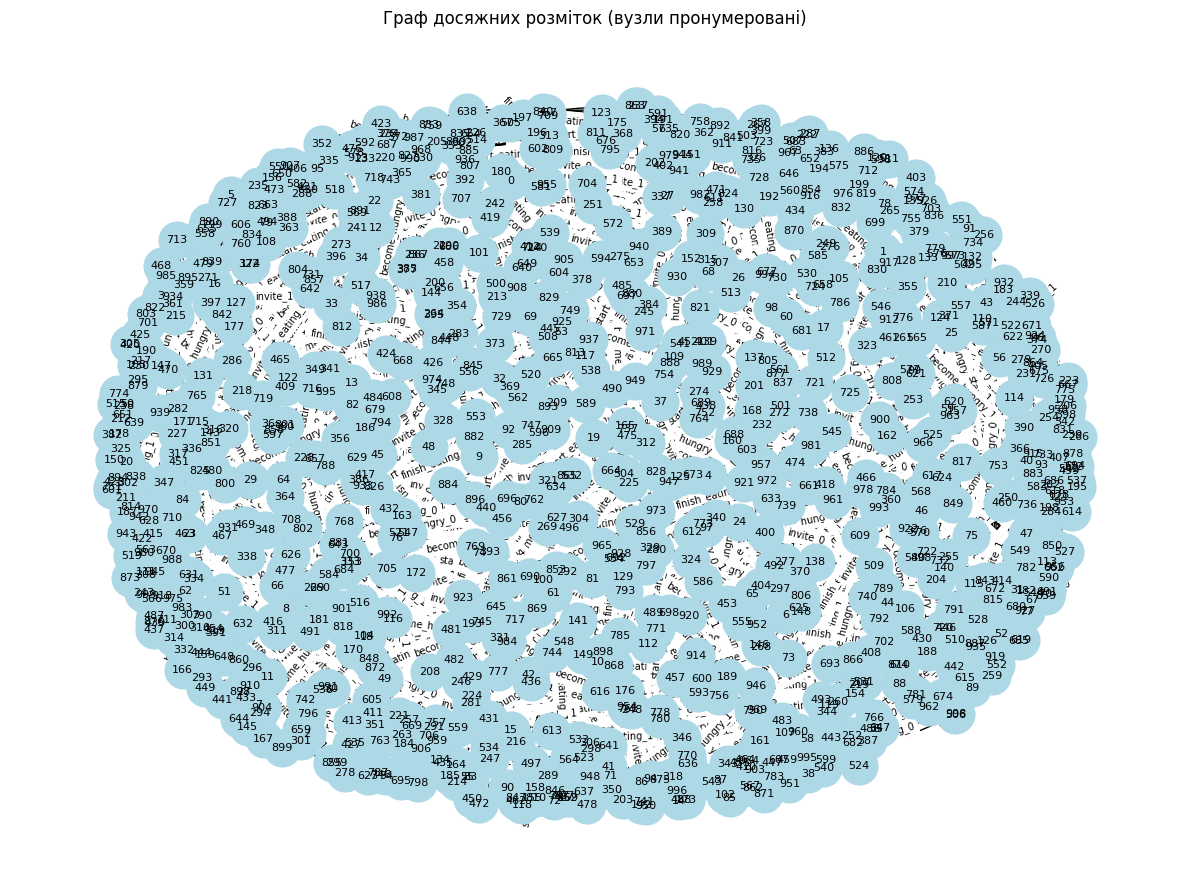


Деталі перших 10 маркувань:
  ID=0, marking={'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 1}
    enabled: ['invite_0', 'become_hungry_0', 'invite_1', 'become_hungry_1']
  ID=1, marking={'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 0}
    enabled: ['start_eating_0', 'become_hungry_1']
  ID=2, marking={'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 1}
    enabled: ['start_eating_0', 'invite_1', 'become_hungry_1']
  ID=3, marking={'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'Thinking_1': 0, 'Hungry_1': 1, 'Eating_1': 0, 'Fork_0': 1, 'Fork_1': 1, 'Invite': 0}
    enabled: ['become_hungry_0', 'start_eating_1']
  ID=4, marking={'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'Thinking_1': 0, 'Hungry_1': 1, 'Eating_1': 0, 'Fork_0': 1, 'Fork_

In [17]:
# Знайдемо тупикові (deadlock) маркування — де жоден перехід не дозволений
deadlocks = []
for i, mt in enumerate(markings):
    m = tuple_to_marking(mt)
    if not enabled_transitions(m):
        deadlocks.append((i, m))
print(f"Кількість тупикових станів: {len(deadlocks)}")
if deadlocks:
    print("Деякі тупикові маркування (показано до 5):")
    for idx, mm in deadlocks[:5]:
        print(idx, mm)

# Побудова та візуалізація графа станів
VISUALIZATION_LIMIT = 1500 # Ліміт для візуалізації графа (ЗБІЛЬШЕНО)

if len(markings) <= VISUALIZATION_LIMIT:
    G = nx.DiGraph()
    # додамо вузли з підписом — короткий
    for i, mt in enumerate(markings):
        label = f"{i}"
        G.add_node(i, label=label)

    for a,b,tr in edges:
        # якщо багато паралельних ребер — додаємо унікальну мітку (візуально поки просто багато стрілок)
        G.add_edge(a, b, label=tr)

    # позиціонування для гарного вигляду
    pos = nx.spring_layout(G, seed=42, k=0.5)

    plt.figure(figsize=(12,9))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, {n: n for n in G.nodes()}, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=12, connectionstyle='arc3,rad=0.1')
    # підписи ребер (якщо їх багато — може бути захаращено)
    edge_labels = {(u,v): d['label'] for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Граф досяжних розміток (вузли пронумеровані)")
    plt.axis('off')
    plt.tight_layout()
    # Видаляємо збереження зображення у файл
    # plt.savefig("reachability_graph.png", dpi=200)
    print("Візуалізація графа...")
    plt.show()
else:
    print(f"Кількість маркувань ({len(markings)}) перевищує ліміт візуалізації ({VISUALIZATION_LIMIT}). Граф не буде відображено.")

# Додатково: виведемо детально перше кілька маркувань з їх дозволеними переходами
print("\nДеталі перших 10 маркувань:")
for i, mt in enumerate(markings[:10]):
    m = tuple_to_marking(mt)
    print(f"  ID={i}, marking={m}")
    print("    enabled:", enabled_transitions(m))

## build_petri_net_model

### Subtask:
Модифікувати визначення мережі Петрі в клітинці `2dab1d60` для реалізації послідовного взяття виделок (варіант 2), а також зберегти механізми запрошення (варіанти 3 та 4). Залишити `N=5` для початкового визначення моделі.


In [18]:
from collections import deque

# --- START of copied dependencies from preceding cells ---
# Petri net parameters from cell 7wblK3PAierU
N = 5  # кількість філософів / вилок (ЗМІНЕНО НА 5 для послідовного взяття)

# Опис мережі: місця (places) і переходи (transitions) з їх входами/виходами (арки з вагою=1)
# Представимо мережу як словники: inputs[tr] = {place: weight}, outputs[tr] = {place: weight}

places = []
for i in range(N):
    places += [f"Thinking_{i}", f"Hungry_{i}", f"Eating_{i}", f"WaitingForRight_{i}"] # Додано WaitingForRight
for i in range(N):
    places.append(f"Fork_{i}")
places.append("Invite")  # місце для запрошення (1 токен)

# Початкове маркування: всі філософи думають, всі вилки вільні, invite = 1, інші 0
initial_marking = {p: 0 for p in places}
for i in range(N):
    initial_marking[f"Thinking_{i}"] = 1
    initial_marking[f"Fork_{i}"] = 1
    initial_marking[f"WaitingForRight_{i}"] = 0 # Явно ініціалізуємо
initial_marking["Invite"] = 1

# Transition rules and helper functions from cell vLRl0hMjinD_
inputs = dict()
outputs = dict()

for i in range(N):
    # invite transition (за наявності Invite) - optional (але наявний)
    t_inv = f"invite_{i}"
    inputs[t_inv] = {f"Thinking_{i}": 1, "Invite": 1}
    outputs[t_inv] = {f"Hungry_{i}": 1}  # запрошення переводить в Hungry (Invite витрачається)

    # direct become hungry (без запрошення) — необов'язковий шлях
    t_direct = f"become_hungry_{i}"
    inputs[t_direct] = {f"Thinking_{i}": 1}
    outputs[t_direct] = {f"Hungry_{i}": 1}

    # NEW: take_left_fork_i
    left = f"Fork_{i}"
    t_take_left = f"take_left_fork_{i}"
    inputs[t_take_left] = {f"Hungry_{i}": 1, left: 1}
    outputs[t_take_left] = {f"WaitingForRight_{i}": 1}

    # NEW: take_right_fork_i
    right = f"Fork_{(i+1)%N}"
    t_take_right = f"take_right_fork_{i}"
    inputs[t_take_right] = {f"WaitingForRight_{i}": 1, right: 1}
    outputs[t_take_right] = {f"Eating_{i}": 1}

    # finish eating: повертає вилки і переходить у Thinking, а також повертає Invite (модель спрощена)
    t_finish = f"finish_eating_{i}"
    inputs[t_finish] = {f"Eating_{i}": 1}
    outputs[t_finish] = {f"Thinking_{i}": 1, left: 1, right: 1, "Invite": 1}

# Список всіх переходів
transitions = list(inputs.keys())

# Функції для роботи з маркуваннями
def marking_to_tuple(m):
    # порядок місць визначений списком places
    return tuple(m[p] for p in places)

def tuple_to_marking(tup):
    return {p: tup[i] for i, p in enumerate(places)}

def enabled_transitions(marking):
    enabled = []
    for tr in transitions:
        req = inputs[tr]
        ok = True
        for p, w in req.items():
            if marking.get(p,0) < w:
                ok = False
                break
        if ok:
            enabled.append(tr)
    return enabled

def fire_transition(marking, tr):
    m = marking.copy()
    for p, w in inputs[tr].items():
        m[p] -= w
    for p, w in outputs[tr].items():
        m[p] = m.get(p,0) + w
    return m
# --- END of copied dependencies ---

# Максимальна кількість станів, які потрібно дослідити, щоб уникнути зависання
MAX_STATES = 1000  # Можна налаштувати (ЗМЕНШЕНО)
PROGRESS_REPORT_INTERVAL = 10000 # Звіт про прогрес кожні N станів

start = initial_marking
start_t = marking_to_tuple(start)

seen = {start_t: 0}  # відмітка -> id
markings = [start_t]
edges = []  # (from_id, to_id, transition)

q = deque([start_t])
state_count = 0

print("Починаємо побудову графа досяжних розміток (BFS)...")
while q:
    cur_t = q.popleft()
    cur_id = seen[cur_t]
    cur_m = tuple_to_marking(cur_t)
    enabled = enabled_transitions(cur_m)

    state_count += 1
    if state_count % PROGRESS_REPORT_INTERVAL == 0:
        print(f"Прогрес: Досліджено {state_count} станів, {len(markings)} унікальних маркувань знайдено.")

    if len(markings) >= MAX_STATES:
        print(f"Досягнуто максимальної кількості станів ({MAX_STATES}). Зупиняємо BFS.")
        break

    for tr in enabled:
        new_m = fire_transition(cur_m, tr)
        new_t = marking_to_tuple(new_m)
        if new_t not in seen:
            seen[new_t] = len(markings)
            markings.append(new_t)
            q.append(new_t)
        edges.append((cur_id, seen[new_t], tr))

# Результати
print(f"Кількість досяжних маркувань: {len(markings)}")
print("Пара прикладів маркувань (перші 5):")
for i, mt in enumerate(markings[:5]):
    print(i, tuple_to_marking(mt))

Починаємо побудову графа досяжних розміток (BFS)...
Досягнуто максимальної кількості станів (1000). Зупиняємо BFS.
Кількість досяжних маркувань: 1000
Пара прикладів маркувань (перші 5):
0 {'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Thinking_3': 1, 'Hungry_3': 0, 'Eating_3': 0, 'WaitingForRight_3': 0, 'Thinking_4': 1, 'Hungry_4': 0, 'Eating_4': 0, 'WaitingForRight_4': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Fork_3': 1, 'Fork_4': 1, 'Invite': 1}
1 {'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Thinking_3': 1, 'Hungry_3': 0, 'Eating_3': 0, 'WaitingForRight_3': 0, 'Thinking_4': 1, 'Hungry_4': 0, 'Eating_4': 0, 'WaitingForRight_4': 0, 'Fork_0': 1, 'Fork_1

## generate_and_visualize_reachability_graph

### Subtask:
Запустити генерацію графа досяжних розміток з новим визначенням мережі Петрі.


**Reasoning**:
The subtask requires executing cell `e7f6ff2d` to find deadlocks and visualize the reachability graph with the newly defined Petri net. This cell was identified as not yet executed.



Кількість тупикових станів: 0
Візуалізація графа...


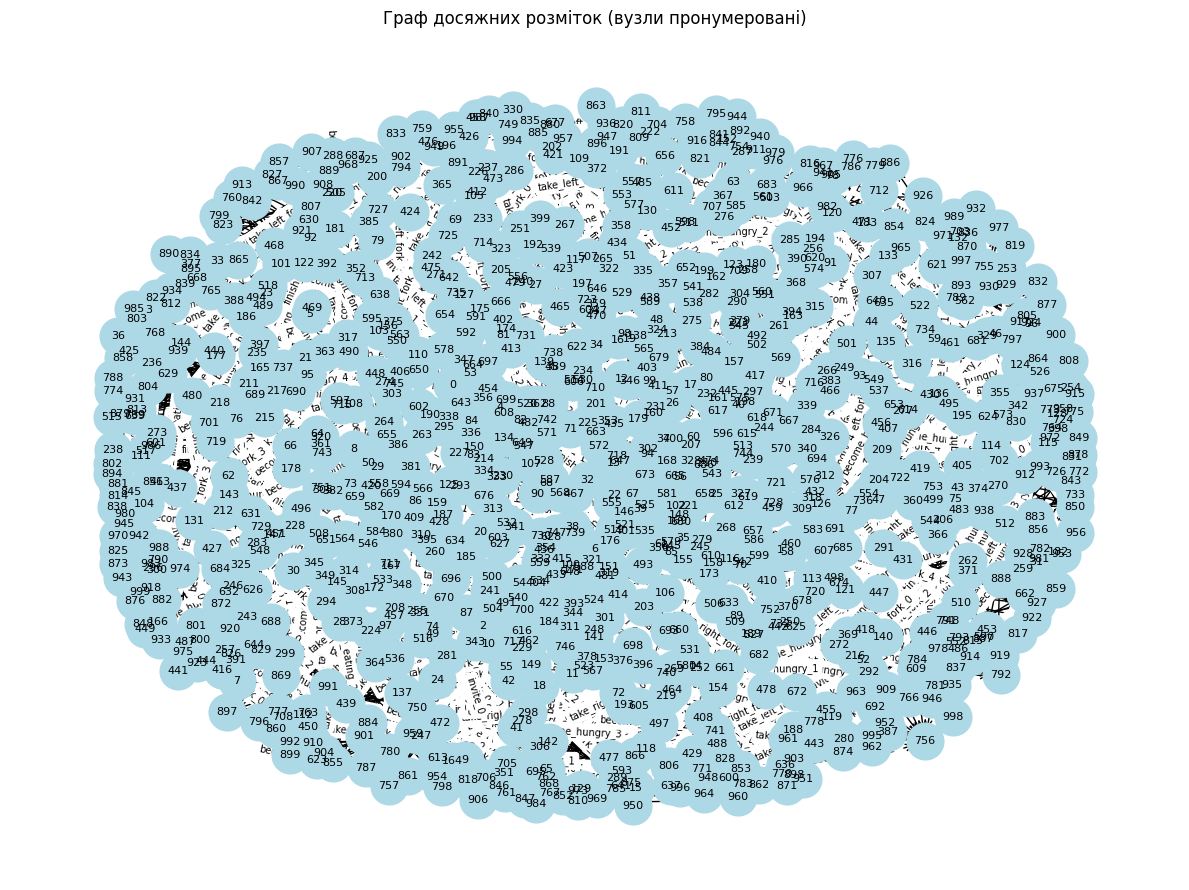


Деталі перших 10 маркувань:
  ID=0, marking={'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Thinking_3': 1, 'Hungry_3': 0, 'Eating_3': 0, 'WaitingForRight_3': 0, 'Thinking_4': 1, 'Hungry_4': 0, 'Eating_4': 0, 'WaitingForRight_4': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Fork_3': 1, 'Fork_4': 1, 'Invite': 1}
    enabled: ['invite_0', 'become_hungry_0', 'invite_1', 'become_hungry_1', 'invite_2', 'become_hungry_2', 'invite_3', 'become_hungry_3', 'invite_4', 'become_hungry_4']
  ID=1, marking={'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Thinking_3': 1, 'Hungry_3': 0, 'Eating_3': 0, 'WaitingForRight_3': 0, 'Thinking_4': 1, 'Hungry_4': 0, 'Eating_4': 0, 'Wai

In [19]:
# Знайдемо тупикові (deadlock) маркування — де жоден перехід не дозволений
deadlocks = []
for i, mt in enumerate(markings):
    m = tuple_to_marking(mt)
    if not enabled_transitions(m):
        deadlocks.append((i, m))
print(f"Кількість тупикових станів: {len(deadlocks)}")
if deadlocks:
    print("Деякі тупикові маркування (показано до 5):")
    for idx, mm in deadlocks[:5]:
        print(idx, mm)

# Побудова та візуалізація графа станів
VISUALIZATION_LIMIT = 1500 # Ліміт для візуалізації графа (ЗБІЛЬШЕНО)

if len(markings) <= VISUALIZATION_LIMIT:
    G = nx.DiGraph()
    # додамо вузли з підписом — короткий
    for i, mt in enumerate(markings):
        label = f"{i}"
        G.add_node(i, label=label)

    for a,b,tr in edges:
        # якщо багато паралельних ребер — додаємо унікальну мітку (візуально поки просто багато стрілок)
        G.add_edge(a, b, label=tr)

    # позиціонування для гарного вигляду
    pos = nx.spring_layout(G, seed=42, k=0.5)

    plt.figure(figsize=(12,9))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, {n: n for n in G.nodes()}, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=12, connectionstyle='arc3,rad=0.1')
    # підписи ребер (якщо їх багато — може бути захаращено)
    edge_labels = {(u,v): d['label'] for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Граф досяжних розміток (вузли пронумеровані)")
    plt.axis('off')
    plt.tight_layout()
    # Видаляємо збереження зображення у файл
    # plt.savefig("reachability_graph.png", dpi=200)
    print("Візуалізація графа...")
    plt.show()
else:
    print(f"Кількість маркувань ({len(markings)}) перевищує ліміт візуалізації ({VISUALIZATION_LIMIT}). Граф не буде відображено.")

# Додатково: виведемо детально перше кілька маркувань з їх дозволеними переходами
print("\nДеталі перших 10 маркувань:")
for i, mt in enumerate(markings[:10]):
    m = tuple_to_marking(mt)
    print(f"  ID={i}, marking={m}")
    print("    enabled:", enabled_transitions(m))

## Visualize reachability graph for N=3

### Subtask:
Modify the Petri net definition to set `N=3` and then generate and visualize the full reachability graph.


In [20]:
from collections import deque

# --- START of copied dependencies from preceding cells ---
# Petri net parameters from cell 7wblK3PAierU
N = 3  # кількість філософів / вилок (ЗМІНЕНО НА 3 для візуалізації)

# Опис мережі: місця (places) і переходи (transitions) з їх входами/виходами (арки з вагою=1)
# Представимо мережу як словники: inputs[tr] = {place: weight}, outputs[tr] = {place: weight}

places = []
for i in range(N):
    places += [f"Thinking_{i}", f"Hungry_{i}", f"Eating_{i}", f"WaitingForRight_{i}"] # Додано WaitingForRight
for i in range(N):
    places.append(f"Fork_{i}")
places.append("Invite")  # місце для запрошення (1 токен)

# Початкове маркування: всі філософи думають, всі вилки вільні, invite = 1, інші 0
initial_marking = {p: 0 for p in places}
for i in range(N):
    initial_marking[f"Thinking_{i}"] = 1
    initial_marking[f"Fork_{i}"] = 1
    initial_marking[f"WaitingForRight_{i}"] = 0 # Явно ініціалізуємо
initial_marking["Invite"] = 1

# Transition rules and helper functions from cell vLRl0hMjinD_
inputs = dict()
outputs = dict()

for i in range(N):
    # invite transition (за наявності Invite) - optional (але наявний)
    t_inv = f"invite_{i}"
    inputs[t_inv] = {f"Thinking_{i}": 1, "Invite": 1}
    outputs[t_inv] = {f"Hungry_{i}": 1}  # запрошення переводить в Hungry (Invite витрачається)

    # direct become hungry (без запрошення) — необов'язковий шлях
    t_direct = f"become_hungry_{i}"
    inputs[t_direct] = {f"Thinking_{i}": 1}
    outputs[t_direct] = {f"Hungry_{i}": 1}

    # NEW: take_left_fork_i
    left = f"Fork_{i}"
    t_take_left = f"take_left_fork_{i}"
    inputs[t_take_left] = {f"Hungry_{i}": 1, left: 1}
    outputs[t_take_left] = {f"WaitingForRight_{i}": 1}

    # NEW: take_right_fork_i
    right = f"Fork_{(i+1)%N}"
    t_take_right = f"take_right_fork_{i}"
    inputs[t_take_right] = {f"WaitingForRight_{i}": 1, right: 1}
    outputs[t_take_right] = {f"Eating_{i}": 1}

    # finish eating: повертає вилки і переходить у Thinking, а також повертає Invite (модель спрощена)
    t_finish = f"finish_eating_{i}"
    inputs[t_finish] = {f"Eating_{i}": 1}
    outputs[t_finish] = {f"Thinking_{i}": 1, left: 1, right: 1, "Invite": 1}

# Список всіх переходів
transitions = list(inputs.keys())

# Функції для роботи з маркуваннями
def marking_to_tuple(m):
    # порядок місць визначений списком places
    return tuple(m[p] for p in places)

def tuple_to_marking(tup):
    return {p: tup[i] for i, p in enumerate(places)}

def enabled_transitions(marking):
    enabled = []
    for tr in transitions:
        req = inputs[tr]
        ok = True
        for p, w in req.items():
            if marking.get(p,0) < w:
                ok = False
                break
        if ok:
            enabled.append(tr)
    return enabled

def fire_transition(marking, tr):
    m = marking.copy()
    for p, w in inputs[tr].items():
        m[p] -= w
    for p, w in outputs[tr].items():
        m[p] = m.get(p,0) + w
    return m
# --- END of copied dependencies ---

# Максимальна кількість станів, які потрібно дослідити, щоб уникнути зависання
MAX_STATES = 1000  # Можна налаштувати (ЗМЕНШЕНО)
PROGRESS_REPORT_INTERVAL = 10000 # Звіт про прогрес кожні N станів

start = initial_marking
start_t = marking_to_tuple(start)

seen = {start_t: 0}  # відмітка -> id
markings = [start_t]
edges = []  # (from_id, to_id, transition)

q = deque([start_t])
state_count = 0

print("Починаємо побудову графа досяжних розміток (BFS)...")
while q:
    cur_t = q.popleft()
    cur_id = seen[cur_t]
    cur_m = tuple_to_marking(cur_t)
    enabled = enabled_transitions(cur_m)

    state_count += 1
    if state_count % PROGRESS_REPORT_INTERVAL == 0:
        print(f"Прогрес: Досліджено {state_count} станів, {len(markings)} унікальних маркувань знайдено.")

    if len(markings) >= MAX_STATES:
        print(f"Досягнуто максимальної кількості станів ({MAX_STATES}). Зупиняємо BFS.")
        break

    for tr in enabled:
        new_m = fire_transition(cur_m, tr)
        new_t = marking_to_tuple(new_m)
        if new_t not in seen:
            seen[new_t] = len(markings)
            markings.append(new_t)
            q.append(new_t)
        edges.append((cur_id, seen[new_t], tr))

# Результати
print(f"Кількість досяжних маркувань: {len(markings)}")
print("Пара прикладів маркувань (перші 5):")
for i, mt in enumerate(markings[:5]):
    print(i, tuple_to_marking(mt))

Починаємо побудову графа досяжних розміток (BFS)...
Досягнуто максимальної кількості станів (1000). Зупиняємо BFS.
Кількість досяжних маркувань: 1002
Пара прикладів маркувань (перші 5):
0 {'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Invite': 1}
1 {'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Invite': 0}
2 {'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Invite': 1}
3 {'Thinki

Кількість тупикових станів: 22
Деякі тупикові маркування (показано до 5):
87 {'Thinking_0': 0, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 1, 'Thinking_1': 0, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 1, 'Thinking_2': 0, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 1, 'Fork_0': 0, 'Fork_1': 0, 'Fork_2': 0, 'Invite': 0}
97 {'Thinking_0': 0, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 1, 'Thinking_1': 0, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 1, 'Thinking_2': 0, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 1, 'Fork_0': 0, 'Fork_1': 0, 'Fork_2': 0, 'Invite': 1}
142 {'Thinking_0': 0, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 1, 'Thinking_1': 0, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 1, 'Thinking_2': 0, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 1, 'Fork_0': 0, 'Fork_1': 0, 'Fork_2': 0, 'Invite': 2}
187 {'Thinking_0': 0, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 1, 'Thinking_1': 0, 'Hungry_1': 0, 'Eating_1'

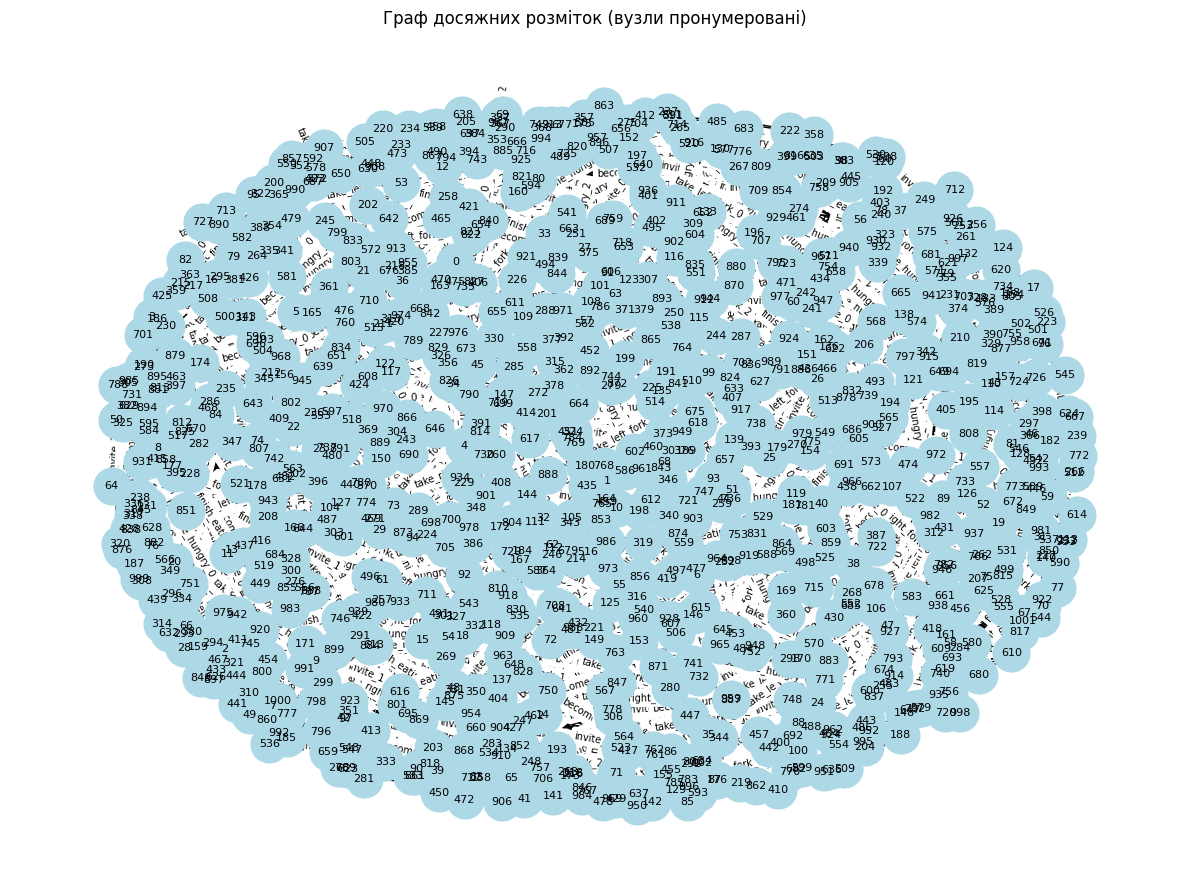


Деталі перших 10 маркувань:
  ID=0, marking={'Thinking_0': 1, 'Hungry_0': 0, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Invite': 1}
    enabled: ['invite_0', 'become_hungry_0', 'invite_1', 'become_hungry_1', 'invite_2', 'become_hungry_2']
  ID=1, marking={'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0, 'Fork_0': 1, 'Fork_1': 1, 'Fork_2': 1, 'Invite': 0}
    enabled: ['take_left_fork_0', 'become_hungry_1', 'become_hungry_2']
  ID=2, marking={'Thinking_0': 0, 'Hungry_0': 1, 'Eating_0': 0, 'WaitingForRight_0': 0, 'Thinking_1': 1, 'Hungry_1': 0, 'Eating_1': 0, 'WaitingForRight_1': 0, 'Thinking_2': 1, 'Hungry_2': 0, 'Eating_2': 0, 'WaitingForRight_2': 0

In [21]:
# Знайдемо тупикові (deadlock) маркування — де жоден перехід не дозволений
deadlocks = []
for i, mt in enumerate(markings):
    m = tuple_to_marking(mt)
    if not enabled_transitions(m):
        deadlocks.append((i, m))
print(f"Кількість тупикових станів: {len(deadlocks)}")
if deadlocks:
    print("Деякі тупикові маркування (показано до 5):")
    for idx, mm in deadlocks[:5]:
        print(idx, mm)

# Побудова та візуалізація графа станів
VISUALIZATION_LIMIT = 1500 # Ліміт для візуалізації графа (ЗБІЛЬШЕНО)

if len(markings) <= VISUALIZATION_LIMIT:
    G = nx.DiGraph()
    # додамо вузли з підписом — короткий
    for i, mt in enumerate(markings):
        label = f"{i}"
        G.add_node(i, label=label)

    for a,b,tr in edges:
        # якщо багато паралельних ребер — додаємо унікальну мітку (візуально поки просто багато стрілок)
        G.add_edge(a, b, label=tr)

    # позиціонування для гарного вигляду
    pos = nx.spring_layout(G, seed=42, k=0.5)

    plt.figure(figsize=(12,9))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, {n: n for n in G.nodes()}, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=12, connectionstyle='arc3,rad=0.1')
    # підписи ребер (якщо їх багато — може бути захаращено)
    edge_labels = {(u,v): d['label'] for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Граф досяжних розміток (вузли пронумеровані)")
    plt.axis('off')
    plt.tight_layout()
    # Видаляємо збереження зображення у файл
    # plt.savefig("reachability_graph.png", dpi=200)
    print("Візуалізація графа...")
    plt.show()
else:
    print(f"Кількість маркувань ({len(markings)}) перевищує ліміт візуалізації ({VISUALIZATION_LIMIT}). Граф не буде відображено.")

# Додатково: виведемо детально перше кілька маркувань з їх дозволеними переходами
print("\nДеталі перших 10 маркувань:")
for i, mt in enumerate(markings[:10]):
    m = tuple_to_marking(mt)
    print(f"  ID={i}, marking={m}")
    print("    enabled:", enabled_transitions(m))

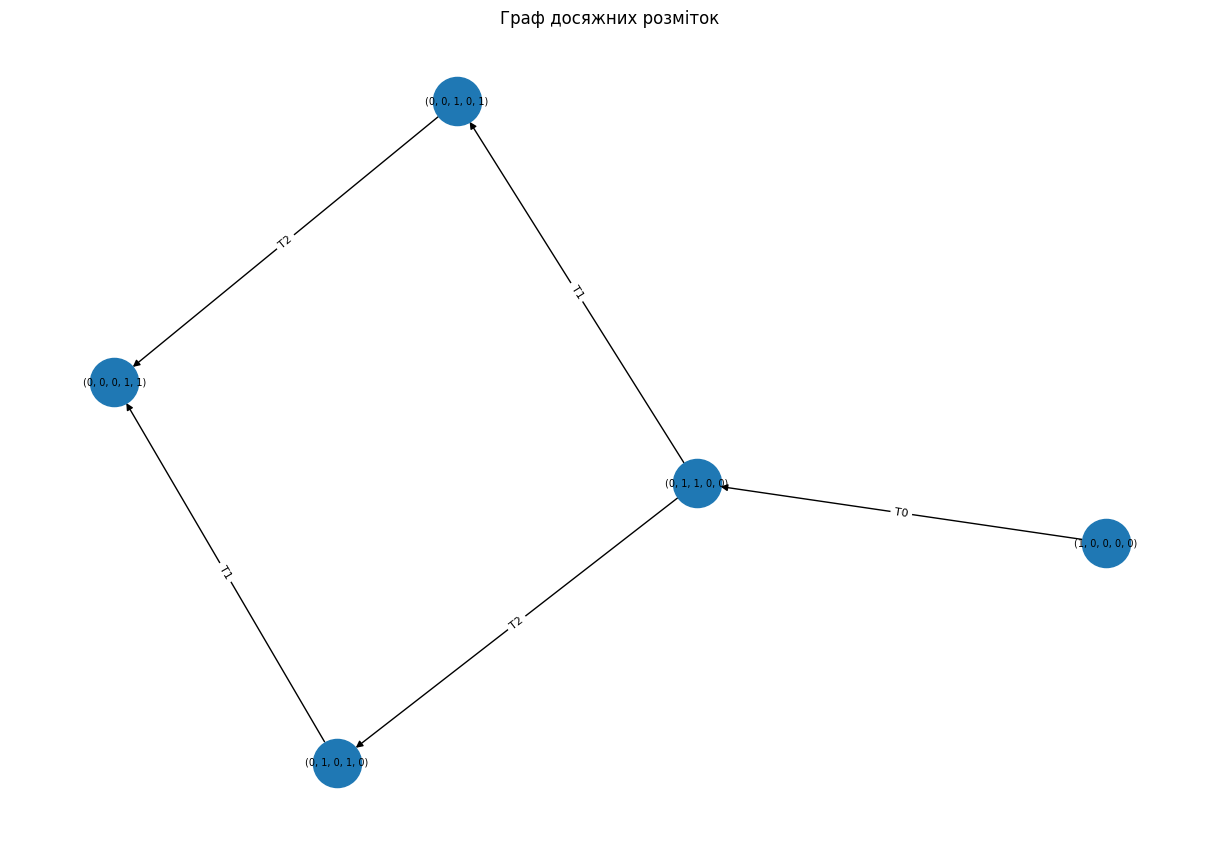

Усього станів: 5

Стан:
(0, 0, 1, 0, 1)
(0, 0, 0, 1, 1)
(0, 1, 0, 1, 0)
(1, 0, 0, 0, 0)
(0, 1, 1, 0, 0)


In [23]:
!pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

# ---- Місця ----
places = ["P0", "P1", "P2", "P3", "P4"]

# Початкове маркування
initial_marking = {p: 0 for p in places}
initial_marking["P0"] = 1

# ---- Переходи і дуги ----
inputs = {
    "T0": {"P0": 1},
    "T1": {"P1": 1},
    "T2": {"P2": 1},
    "T3": {"P0": 1, "P4": 1, "P3": 1},
}

outputs = {
    "T0": {"P1": 1, "P2": 1},
    "T1": {"P4": 1},
    "T2": {"P3": 1},
    "T3": {"P0": 1},
}

transitions = list(inputs.keys())


# ---- Функції ----
def marking_to_tuple(m):
    return tuple(m[p] for p in places)

def tuple_to_marking(t):
    return {places[i]: t[i] for i in range(len(places))}

def enabled_transitions(m):
    enabled = []
    for t in transitions:
        ok = True
        for p, w in inputs[t].items():
            if m[p] < w:
                ok = False
                break
        if ok:
            enabled.append(t)
    return enabled

def fire(m, t):
    new = m.copy()
    for p, w in inputs[t].items():
        new[p] -= w
    for p, w in outputs[t].items():
        new[p] += w
    return new


# ---- Побудова графу досяжних маркувань ----
start = marking_to_tuple(initial_marking)
queue = [start]
visited = {start}
edges = []

while queue:
    cur = queue.pop(0)
    m = tuple_to_marking(cur)
    for t in enabled_transitions(m):
        new_m = fire(m, t)
        new_t = marking_to_tuple(new_m)
        edges.append((cur, new_t, t))
        if new_t not in visited:
            visited.add(new_t)
            queue.append(new_t)

# ---- Побудова графу ----
G = nx.DiGraph()
for node in visited:
    G.add_node(node)

for a, b, t in edges:
    G.add_edge(a, b, label=t)

pos = nx.spring_layout(G, seed=1)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=1200, font_size=7)
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Граф досяжних розміток")
plt.show()

print("Усього станів:", len(visited))
print("\nСтан:")
for s in visited:
    print(s)
